# Section A: Binary Classification Model for Bird Flu Outbreak Prediction

This notebook demonstrates the process of building a binary classification model to predict bird flu outbreaks based on weather data.

## 1. Purpose and Objectives  
The notebook aims to build a binary classification model to predict bird flu outbreaks using weather data. The primary objectives are:  
- **Data Loading & Preprocessing:** Import and clean datasets (weather, bird flu outbreaks in flocks, wild birds, and mammals).  
- **Feature Engineering:** Create a merged dataset suitable for modeling.  
- **Model Training:** Train a Random Forest Classifier for outbreak prediction.  
- **Model Evaluation:** Use metrics such as classification reports, confusion matrices, and ROC curves.  
- **Feature Analysis:** Identify key factors driving predictions through feature importance analysis.  

---

## 2. Data Processing Steps  
### Data Loading  
- **Datasets:** Weather data and bird flu outbreak records (flocks, wild birds, mammals).  

### Preprocessing  
- **Date Features:** Extracted Month and Year from outbreak dates.  
- **Geographic Cleaning:** Cleaned and standardized county names.  
- **Weather Aggregation:** Created a monthly weather dataset using cross-joins.  

### Feature Engineering  
- **Outbreak Counts:** Calculated monthly outbreak totals per state, county, and month.  
- **Merged Data:** Combined weather and outbreak records into a single dataset.  
- **Target Variable:** Created a binary target (`has_outbreak`) indicating outbreak presence.  
- **Selected Features:** Included temperature, precipitation, anomalies, and month for modeling.  

---

## 3. Model and Architecture  
### Model Used: Random Forest Classifier  
#### Model Workflow:  
1. **Data Splitting:** Partitioned into training and testing sets.  
2. **Feature Scaling:** Applied `StandardScaler` for normalization.  
3. **Class Imbalance Handling:** Used SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance. SMOTE (Synthetic Minority Over-sampling Technique) is a technique used in machine learning and data preprocessing to address class imbalance in datasets. It works by generating synthetic examples of the minority class rather than just duplicating existing instances.   
4. **Model Training:** Trained a Random Forest Classifier on resampled data.  

---

## 4. Key Findings and Results  
### Model Evaluation Metrics:  
- **Classification Report:**  
  - **Overall Accuracy:** 90%  
  - **Positive Class (Outbreak):**  
    - Precision: 56%  
    - Recall: 47%  
    - F1-score: 51%  

- **Confusion Matrix:**  
  - Visualizes true positives, true negatives, false positives, and false negatives.  

- **ROC Curve and AUC:**  
  - **AUC (Area Under Curve):** 0.72  

### Feature Importance:  
- **Key Drivers of Predictions:**  
  - **Temperature Anomaly (1901-2000 base period)**  
  - **Z Anomaly (1901-2000 base period)**  

---

## 5. Visualizations and Metrics  
The notebook provides the following visualizations:  
- **Classification Report:** Displays precision, recall, F1-score, and support.  
- **Confusion Matrix:** Heatmap visualizing model performance.  
- **ROC Curve and AUC:** Plots the model's receiver operating characteristic curve.  
- **Feature Importance Plot:** Bar chart showing the most important features in predictions.  

---

## Conclusion  
This notebook demonstrates a complete machine learning pipeline for predicting bird flu outbreaks using weather data. Key insights include:  
- The model achieves high overall accuracy (90%), but precision and recall for outbreaks remain low, indicating room for improvement.  
- Feature importance analysis highlights that temperature anomalies are significant predictors of outbreaks.  
- Potential Improvements:  
  - Test alternative models (e.g., XGBoost, Gradient Boosting).  
  - Further feature engineering (e.g., adding lagged weather variables).  
  - Use ensemble methods for improved recall.  

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualization
plt.style.use('seaborn-v0_8')

## Data Loading and Preprocessing

In [2]:
# Load datasets
weather_df = pd.read_csv('./Data/weather.csv')
flocks_df = pd.read_csv('./Data/hpai-flocks.csv')
wild_birds_df = pd.read_csv('./Data/hpai-wild-birds1.csv')
mammals_df = pd.read_csv('./Data/hpai-mammals.csv')

# Process dates for outbreak data
def process_dates(df):
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])
    df['Month'] = df['Outbreak Date'].dt.month
    df['Year'] = df['Outbreak Date'].dt.year
    return df

flocks_df = process_dates(flocks_df)
wild_birds_df = process_dates(wild_birds_df)
mammals_df = process_dates(mammals_df)

## Feature Engineering

In [3]:
# Create monthly outbreak summaries
all_outbreaks = pd.concat([
    flocks_df[['State', 'County', 'Month', 'Year']].assign(dataset='flocks'),
    wild_birds_df[['State', 'County', 'Month', 'Year']].assign(dataset='wild_birds'),
    mammals_df[['State', 'County', 'Month', 'Year']].assign(dataset='mammals')
])

# Count outbreaks per county per month
outbreak_counts = all_outbreaks.groupby(['State', 'County', 'Month', 'Year']).size().reset_index(name='outbreak_count')

# Clean county names
outbreak_counts['County'] = outbreak_counts['County'].str.strip()
weather_df['County'] = weather_df['County'].str.strip()

# Create a cross join of weather data with months (1-12)
weather_monthly = pd.DataFrame({
    key: np.repeat(weather_df[key].values, 12) 
    for key in weather_df.columns
})
weather_monthly['Month'] = np.tile(np.arange(1, 13), len(weather_df))

## Data Merging and Preparation

In [4]:
# Merge weather data with outbreak counts
merged_data = pd.merge(
    weather_monthly,
    outbreak_counts,
    on=['State', 'County', 'Month'],
    how='left'
)

# Fill NaN values and create binary target
merged_data['outbreak_count'] = merged_data['outbreak_count'].fillna(0)
merged_data['has_outbreak'] = (merged_data['outbreak_count'] > 0).astype(int)

# Select features
features = ['Temp', 'Temp Anomaly (1901-2000 base period)', 
           'Precipitation', 'Prec Anomaly (1901-2000 base period)',
           'Z Palmer Index', 'Z Anomaly (1901-2000 base period)',
           'Month']

X = merged_data[features]
y = merged_data['has_outbreak']

## Model Training and Evaluation

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# Train binary classification model
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = clf.predict(X_test_scaled)
y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

## Model Performance Analysis

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6704
           1       0.54      0.43      0.48       867

    accuracy                           0.89      7571
   macro avg       0.73      0.69      0.71      7571
weighted avg       0.88      0.89      0.89      7571



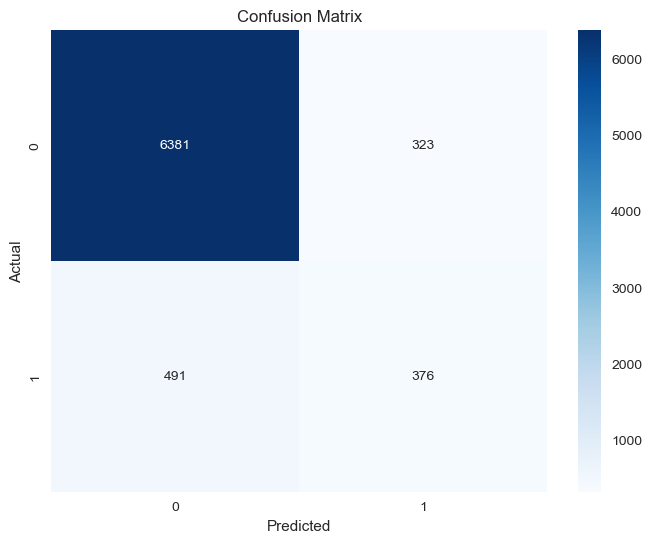

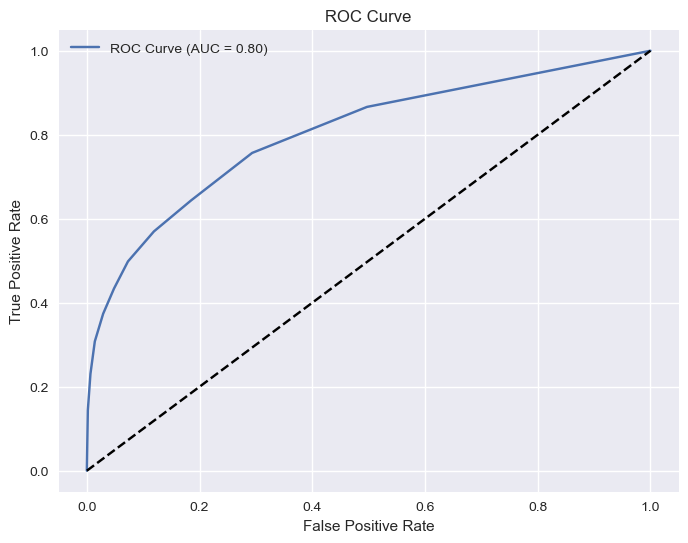

In [6]:
# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature Importance Analysis

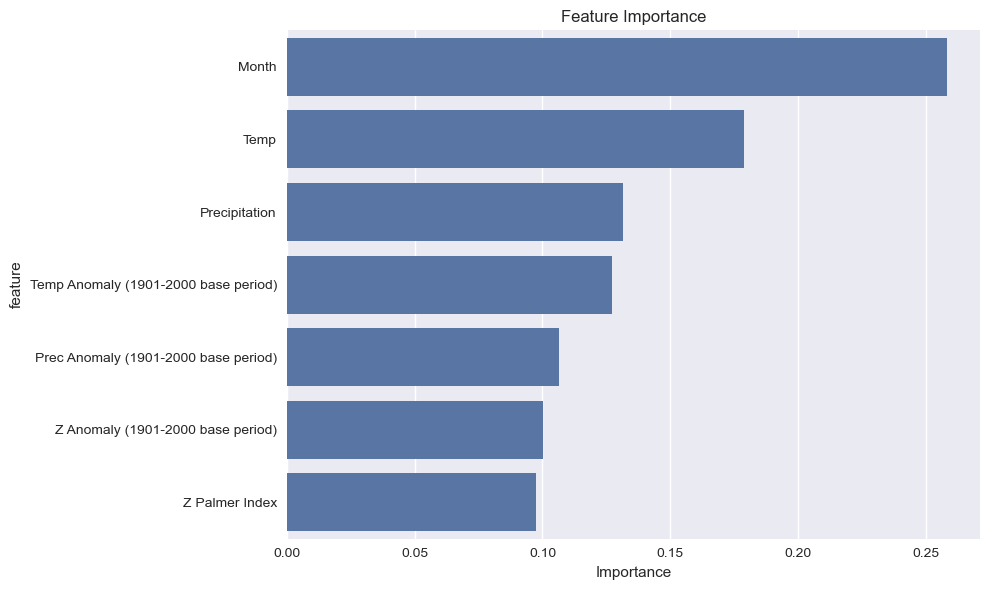

In [7]:
# Calculate and plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

# Hyperparameter tuning using GridSearchCV

In [8]:
# # Define parameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
#                            param_grid=param_grid,
#                            cv=3,
#                            scoring='f1',
#                            verbose=2,
#                            n_jobs=-1)

# # Fit GridSearchCV
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Best parameters and model
# print('Best Parameters:', grid_search.best_params_)
# best_model = grid_search.best_estimator_

# # Evaluate the tuned model
# y_pred_tuned = best_model.predict(X_test_scaled)
# print('Classification Report (Tuned Model):')
# print(classification_report(y_test, y_pred_tuned))

## Model Performance Analysis (After Tuning)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6704
           1       0.54      0.43      0.48       867

    accuracy                           0.89      7571
   macro avg       0.73      0.69      0.71      7571
weighted avg       0.88      0.89      0.89      7571



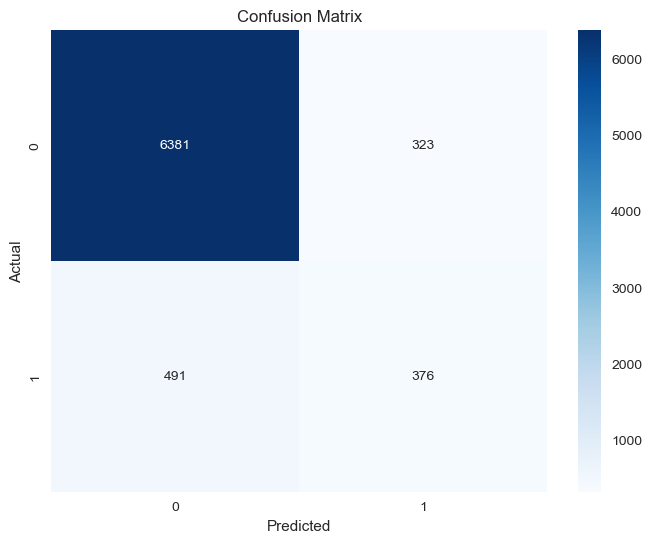

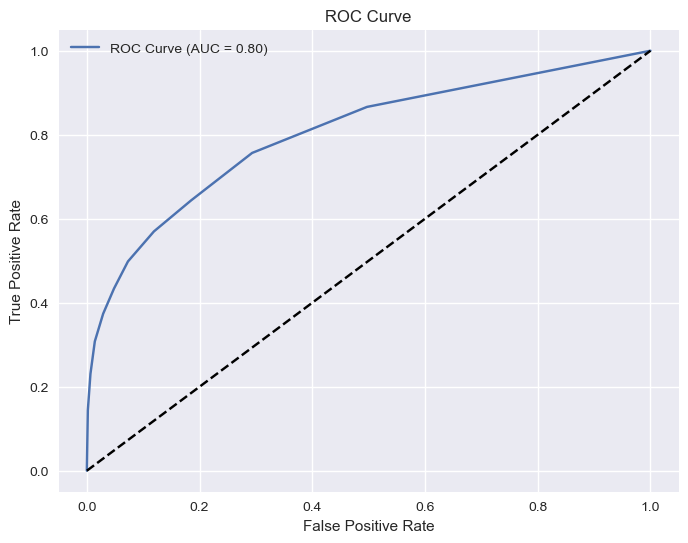

In [9]:
# Print classification report
print('Classification Report:')
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Section B: H5N1 Outbreak Prediction (Classification Model)

In [10]:
# Read the datasets

wildbirds = pd.read_csv("./data/hpai-wild-birds1.csv")
wildbirds = wildbirds.rename(columns={'Date Detected': 'Outbreak Date'})
wildbirds_df = wildbirds[wildbirds['HPAI Strain'].str.contains(r'\bH5N1\b|\bH5\b', na=False)]
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,Sampling Method,Submitting Agency
0,California,Yolo,2/10/2025,EA H5,Western gull,Wild bird,Morbidity/Mortality,UC Davis
1,North Carolina,Buncombe,2/10/2025,EA H5,Cackling goose,Captive wild bird,Morbidity/Mortality,Private (non-government) submission
2,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
3,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS
4,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird,Live bird,SCWDS


In [11]:
# Clean the dataset by dropping unimportant columns.

wildbirds_df = wildbirds_df.drop(columns = ['Sampling Method', 'Submitting Agency'])
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification
0,California,Yolo,2/10/2025,EA H5,Western gull,Wild bird
1,North Carolina,Buncombe,2/10/2025,EA H5,Cackling goose,Captive wild bird
2,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird
3,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird
4,Louisiana,Cameron,2/10/2025,EA/AM H5N1,Blue-winged teal,Wild bird


In [12]:
# Function to convert Date to Day, Month and Year

def convert_date(date):
    return pd.Series([date.year, date.month, date.day], index=["year", "month", "day"])


In [13]:
wildbirds_df["Outbreak Date"] = pd.to_datetime(wildbirds_df["Outbreak Date"],errors='coerce')
wildbirds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11953 entries, 0 to 11965
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                11953 non-null  object        
 1   County               11953 non-null  object        
 2   Outbreak Date        11953 non-null  datetime64[ns]
 3   HPAI Strain          11953 non-null  object        
 4   Bird Species         11953 non-null  object        
 5   WOAH Classification  11953 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 653.7+ KB


In [14]:
wildbirds_df.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification
0,California,Yolo,2025-02-10,EA H5,Western gull,Wild bird
1,North Carolina,Buncombe,2025-02-10,EA H5,Cackling goose,Captive wild bird
2,Louisiana,Cameron,2025-02-10,EA/AM H5N1,Blue-winged teal,Wild bird
3,Louisiana,Cameron,2025-02-10,EA/AM H5N1,Blue-winged teal,Wild bird
4,Louisiana,Cameron,2025-02-10,EA/AM H5N1,Blue-winged teal,Wild bird


In [15]:
# Read US counties dataset
us_county_fips=pd.read_csv("./data/US_Counties.csv")
us_county_fips=us_county_fips.rename(columns={'state_name':'State',"county":"County","county_fips":"FIPS Code","lat":"Latitude","lng":"Longitude"})
us_county_fips=us_county_fips.drop(columns=['state_id','population'])

us_county_fips.head()

,State,County,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,1001,32.5349,-86.6427
1,Alabama,Baldwin,1003,30.7277,-87.7226
2,Alabama,Barbour,1005,31.8696,-85.3932
3,Alabama,Bibb,1007,32.9986,-87.1265
4,Alabama,Blount,1009,33.9809,-86.5674


In [16]:
us_county_fips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3144 entries, 0 to 3143
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   State      3144 non-null   object 
 1   County     3144 non-null   object 
 2   FIPS Code  3144 non-null   int64  
 3   Latitude   3144 non-null   float64
 4   Longitude  3144 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 122.9+ KB


In [17]:
weather_df=pd.read_csv("./data/weather_cleaned.csv")
weather_df.head()

,State,County,Temp,Precipitation
0,Alabama,Autauga,65.9,52.43
1,Alabama,Baldwin,68.7,60.71
2,Alabama,Barbour,66.4,55.97
3,Alabama,Bibb,64.5,46.88
4,Alabama,Blount,63.1,47.63


In [18]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3107 entries, 0 to 3106
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   State          3107 non-null   object 
 1   County         3107 non-null   object 
 2   Temp           3107 non-null   float64
 3   Precipitation  3107 non-null   float64
dtypes: float64(2), object(2)
memory usage: 97.2+ KB


In [19]:
# Reading the mammals outbreak datasets
mammal_df = pd.read_csv("./data/HPAI Detections in Mammals.csv")
mammal_df = mammal_df.rename(columns={'Date Detected':'Outbreak Date','Species':'Mammal Species'})
mammal_df["Outbreak Date"] = pd.to_datetime(mammal_df["Outbreak Date"],errors='coerce')
mammal_df=mammal_df.drop(columns=['Date Collected'])
mammal_df.head()

,State,County,Outbreak Date,HPAI Strain,Mammal Species
0,Oregon,Multnomah,2025-02-10,EA H5N1,Domestic cat
1,Montana,Flathead,2025-02-10,EA AM H5N1,Domestic cat
2,California,San Mateo,2025-02-05,EA H5,Domestic cat
3,Colorado,Douglas,2025-01-31,EA H5N1,Domestic cat
4,California,Contra Costa,2025-01-24,EA H5,Domestic cat


In [20]:
# Read mammal df data types
mammal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           493 non-null    object        
 1   County          493 non-null    object        
 2   Outbreak Date   493 non-null    datetime64[ns]
 3   HPAI Strain     493 non-null    object        
 4   Mammal Species  493 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 19.4+ KB


In [21]:
# Reading he backyardflock datasets

backyardflock = pd.read_csv("./data/backyard_flock_old.csv")
backyardflock = backyardflock.rename(columns={'Outbreak Date': 'Outbreak Date'})
backyardflock["Outbreak Date"] = pd.to_datetime(backyardflock["Outbreak Date"],errors='coerce')
#backyardflock=backyardflock.drop(columns=['FullGeoName','FIPS Codes'])
backyardflock.head()

,County,State,Outbreak Date,Flock Type,Flock Size
0,Ottawa,Michigan,2024-12-31,Commercial Turkey Meat Bird,29400
1,Riverside,California,2024-12-31,Commercial Table Egg Layer,181300
2,Spartanburg,South Carolina,2024-12-31,Commercial Upland Gamebird Producer,920
3,Butte,California,2024-12-31,WOAH Non-Poultry,70
4,Miner,South Dakota,2024-12-31,WOAH Poultry,1500


In [22]:
backyardflock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1554 entries, 0 to 1553
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   County         1554 non-null   object        
 1   State          1554 non-null   object        
 2   Outbreak Date  1554 non-null   datetime64[ns]
 3   Flock Type     1554 non-null   object        
 4   Flock Size     1554 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 60.8+ KB


In [23]:
# Combine us county fips df with wild birds

merge_df1=wildbirds_df.merge(us_county_fips,on=['State','County'], how='outer')
#merge_df1=merge_df1.merge(bird_migrate_df,on=['Month','Day','Year'], how='outer')
merge_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13911 entries, 0 to 13910
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                13911 non-null  object        
 1   County               13911 non-null  object        
 2   Outbreak Date        11974 non-null  datetime64[ns]
 3   HPAI Strain          11974 non-null  object        
 4   Bird Species         11974 non-null  object        
 5   WOAH Classification  11974 non-null  object        
 6   FIPS Code            13753 non-null  float64       
 7   Latitude             13753 non-null  float64       
 8   Longitude            13753 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(5)
memory usage: 978.2+ KB


In [24]:
merge_df1.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427
1,Alabama,Baldwin,2025-02-03,EA H5,House finch,Wild bird,1003.0,30.7277,-87.7226
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226


In [25]:
# Merge the combined dataframe with backyard flock dataframe
merge_df2=merge_df1.merge(backyardflock,on=['State','County','Outbreak Date'], how='outer')
merge_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15443 entries, 0 to 15442
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                15443 non-null  object        
 1   County               15443 non-null  object        
 2   Outbreak Date        13506 non-null  datetime64[ns]
 3   HPAI Strain          11985 non-null  object        
 4   Bird Species         11985 non-null  object        
 5   WOAH Classification  11985 non-null  object        
 6   FIPS Code            13764 non-null  float64       
 7   Latitude             13764 non-null  float64       
 8   Longitude            13764 non-null  float64       
 9   Flock Type           1585 non-null   object        
 10  Flock Size           1585 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 1.3+ MB


In [26]:
merge_df2.head()

,State,County,Outbreak Date,HPAI Strain,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN


In [27]:
# Merge mammals data to the merged dataframe
merge_df3=merge_df2.merge(mammal_df,on=['State','County','Outbreak Date'], how='outer')
merge_df3.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN


In [28]:
merge_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16850 entries, 0 to 16849
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                16850 non-null  object        
 1   County               16850 non-null  object        
 2   Outbreak Date        14913 non-null  datetime64[ns]
 3   HPAI Strain_x        13027 non-null  object        
 4   Bird Species         13027 non-null  object        
 5   WOAH Classification  13027 non-null  object        
 6   FIPS Code            14806 non-null  float64       
 7   Latitude             14806 non-null  float64       
 8   Longitude            14806 non-null  float64       
 9   Flock Type           1585 non-null   object        
 10  Flock Size           1585 non-null   float64       
 11  HPAI Strain_y        1543 non-null   object        
 12  Mammal Species       1543 non-null   object        
dtypes: datetime64[ns](1), float64(4

In [29]:
# Merge weather data to the dataframe
merge_df4=merge_df3.merge(weather_df,on=['State','County'], how='left')
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Fill the missing temperature and precipitation rows with mean values


merge_df4['Temp'] = merge_df4.groupby(['State', 'County'])['Temp'].ffill().bfill()
merge_df4['Precipitation'] = merge_df4.groupby(['State', 'County'])['Precipitation'].ffill().bfill()
 
   
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,70.1,65.07
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07


In [31]:
# Display the merged dataframe types
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16850 entries, 0 to 16849
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                16850 non-null  object        
 1   County               16850 non-null  object        
 2   Outbreak Date        14913 non-null  datetime64[ns]
 3   HPAI Strain_x        13027 non-null  object        
 4   Bird Species         13027 non-null  object        
 5   WOAH Classification  13027 non-null  object        
 6   FIPS Code            14806 non-null  float64       
 7   Latitude             14806 non-null  float64       
 8   Longitude            14806 non-null  float64       
 9   Flock Type           1585 non-null   object        
 10  Flock Size           1585 non-null   float64       
 11  HPAI Strain_y        1543 non-null   object        
 12  Mammal Species       1543 non-null   object        
 13  Temp                 15576 non-

### Select Target Variable

#### Define a positive case (Outbreak =1)
    If an H5N1 outbreak was recorded at a given state, county and date, label it as 1.
#### Define a Negative case (Outbreak =0)
    For locations and times where no outbreak was recorded, assign 0.

In [32]:
# Create target column for Outbreak data

merge_df4[['Year','Month','Day']]=merge_df4['Outbreak Date'].apply(convert_date)
merge_df4['Outbreak Occurred'] = merge_df4['Outbreak Date'].notna().astype(int)
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,70.1,65.07,NaN,NaN,NaN,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1


In [33]:
# Check the value counts of target column "Outbreak occured"
merge_df4['Outbreak Occurred'].value_counts()

Outbreak Occurred
1    14913
0     1937
Name: count, dtype: int64

In [34]:
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,Alabama,Autauga,NaT,NaN,NaN,NaN,1001.0,32.5349,-86.6427,NaN,NaN,NaN,NaN,70.1,65.07,NaN,NaN,NaN,0
1,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1
2,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1
3,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1
4,Alabama,Baldwin,2023-03-01,EA/AM H5N1,Black Vulture,Wild bird,1003.0,30.7277,-87.7226,NaN,NaN,NaN,NaN,70.1,65.07,2023.0,3.0,1.0,1


In [35]:
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16850 entries, 0 to 16849
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                16850 non-null  object        
 1   County               16850 non-null  object        
 2   Outbreak Date        14913 non-null  datetime64[ns]
 3   HPAI Strain_x        13027 non-null  object        
 4   Bird Species         13027 non-null  object        
 5   WOAH Classification  13027 non-null  object        
 6   FIPS Code            14806 non-null  float64       
 7   Latitude             14806 non-null  float64       
 8   Longitude            14806 non-null  float64       
 9   Flock Type           1585 non-null   object        
 10  Flock Size           1585 non-null   float64       
 11  HPAI Strain_y        1543 non-null   object        
 12  Mammal Species       1543 non-null   object        
 13  Temp                 15576 non-

In [36]:
# Encoding the categorical columns to numerical data
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

# Fit and transform categorical columns
categorical_cols = ['State', 'County', 'HPAI Strain_x','HPAI Strain_y','Flock Type', 'Bird Species', 'WOAH Classification','Mammal Species']

for col in categorical_cols:
    merge_df4[col] = encoder.fit_transform(merge_df4[col])


merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,0,84,NaT,9,231,3,1001.0,32.5349,-86.6427,23,NaN,3,40,70.1,65.07,NaN,NaN,NaN,0
1,0,91,2023-03-01,7,22,2,1003.0,30.7277,-87.7226,23,NaN,3,40,70.1,65.07,2023.0,3.0,1.0,1
2,0,91,2023-03-01,7,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,70.1,65.07,2023.0,3.0,1.0,1
3,0,91,2023-03-01,7,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,70.1,65.07,2023.0,3.0,1.0,1
4,0,91,2023-03-01,7,17,2,1003.0,30.7277,-87.7226,23,NaN,3,40,70.1,65.07,2023.0,3.0,1.0,1


In [37]:
# dipaly the merged dataframe
merge_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16850 entries, 0 to 16849
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   State                16850 non-null  int32         
 1   County               16850 non-null  int32         
 2   Outbreak Date        14913 non-null  datetime64[ns]
 3   HPAI Strain_x        16850 non-null  int32         
 4   Bird Species         16850 non-null  int32         
 5   WOAH Classification  16850 non-null  int32         
 6   FIPS Code            14806 non-null  float64       
 7   Latitude             14806 non-null  float64       
 8   Longitude            14806 non-null  float64       
 9   Flock Type           16850 non-null  int32         
 10  Flock Size           1585 non-null   float64       
 11  HPAI Strain_y        16850 non-null  int32         
 12  Mammal Species       16850 non-null  int32         
 13  Temp                 15576 non-

In [38]:
# Handle missing values

merge_df4=merge_df4.fillna(0) # Replace all NaN with 0
merge_df4.head()

,State,County,Outbreak Date,HPAI Strain_x,Bird Species,WOAH Classification,FIPS Code,Latitude,Longitude,Flock Type,Flock Size,HPAI Strain_y,Mammal Species,Temp,Precipitation,Year,Month,Day,Outbreak Occurred
0,0,84,0,9,231,3,1001.0,32.5349,-86.6427,23,0.0,3,40,70.1,65.07,0.0,0.0,0.0,0
1,0,91,2023-03-01 00:00:00,7,22,2,1003.0,30.7277,-87.7226,23,0.0,3,40,70.1,65.07,2023.0,3.0,1.0,1
2,0,91,2023-03-01 00:00:00,7,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,70.1,65.07,2023.0,3.0,1.0,1
3,0,91,2023-03-01 00:00:00,7,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,70.1,65.07,2023.0,3.0,1.0,1
4,0,91,2023-03-01 00:00:00,7,17,2,1003.0,30.7277,-87.7226,23,0.0,3,40,70.1,65.07,2023.0,3.0,1.0,1


In [39]:
# Rename the strains column names

merge_df4=merge_df4.rename(columns={'HPAI Strain_x': 'HPAI Wildbird Strain', 'HPAI Strain_y': 'HPAI Mammal Strain'})
merge_df4.to_csv("./data/final_dataset.csv")
# Remove the outbreak date column as it is already convered to Year, Month, Day columns
#merge_df4= merge_df4[merge_df4['Month'] != 0]
encoded_df=merge_df4.drop(columns=['Outbreak Date'])

encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16850 entries, 0 to 16849
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   State                 16850 non-null  int32  
 1   County                16850 non-null  int32  
 2   HPAI Wildbird Strain  16850 non-null  int32  
 3   Bird Species          16850 non-null  int32  
 4   WOAH Classification   16850 non-null  int32  
 5   FIPS Code             16850 non-null  float64
 6   Latitude              16850 non-null  float64
 7   Longitude             16850 non-null  float64
 8   Flock Type            16850 non-null  int32  
 9   Flock Size            16850 non-null  float64
 10  HPAI Mammal Strain    16850 non-null  int32  
 11  Mammal Species        16850 non-null  int32  
 12  Temp                  16850 non-null  float64
 13  Precipitation         16850 non-null  float64
 14  Year                  16850 non-null  float64
 15  Month              

In [40]:
# Correlation map
correlation_df=encoded_df.drop(columns=['State','County','FIPS Code','WOAH Classification','Day','Year'])
correlation_df.corr()

,HPAI Wildbird Strain,Bird Species,Latitude,Longitude,Flock Type,Flock Size,HPAI Mammal Strain,Mammal Species,Temp,Precipitation,Month,Outbreak Occurred
HPAI Wildbird Strain,1.000000,0.488618,-0.412444,0.417166,-0.286637,0.091788,0.022245,0.080303,0.006145,-0.006461,-0.290588,-0.460425
Bird Species,0.488618,1.000000,-0.404127,0.398891,-0.299939,0.098473,-0.082709,-0.040561,-0.006427,-0.010301,-0.275745,-0.473996
Latitude,-0.412444,-0.404127,1.000000,-0.887566,0.550926,-0.179292,0.185255,0.134144,-0.099631,-0.091903,0.016376,-0.057289
Longitude,0.417166,0.398891,-0.887566,1.000000,-0.537238,0.173287,-0.104201,-0.028862,0.012276,-0.073760,-0.063965,0.063170
Flock Type,-0.286637,-0.299939,0.550926,-0.537238,1.000000,-0.384807,-0.065947,-0.069557,-0.026677,-0.004909,-0.025065,-0.085130
Flock Size,0.091788,0.098473,-0.179292,0.173287,-0.384807,1.000000,0.021570,0.022751,0.016624,0.018951,0.003930,0.027844
HPAI Mammal Strain,0.022245,-0.082709,0.185255,-0.104201,-0.065947,0.021570,1.000000,0.831708,0.049473,0.052508,0.052022,-0.100619
Mammal Species,0.080303,-0.040561,0.134144,-0.028862,-0.069557,0.022751,0.831708,1.000000,0.021558,0.025341,0.055925,-0.106127
Temp,0.006145,-0.006427,-0.099631,0.012276,-0.026677,0.016624,0.049473,0.021558,1.000000,0.779863,0.000003,-0.051671
Precipitation,-0.006461,-0.010301,-0.091903,-0.073760,-0.004909,0.018951,0.052508,0.025341,0.779863,1.000000,0.040724,-0.056564


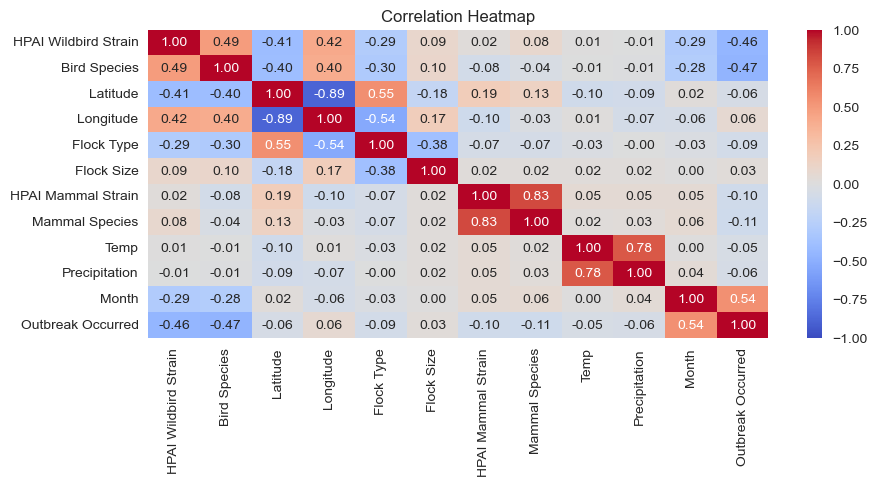

In [41]:
# Plot the correlation

plt.figure(figsize=(10, 4))
sns.heatmap(correlation_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Key Observations from the Correlation Matrix:

#### Month and Outbreak Occurred (0.55 correlation):
A moderate positive correlation suggests that outbreaks may occur more frequently during specific months, potentially correlating with seasonal patterns (e.g., migratory periods).

#### HPAI Mammal Strain and Mammal Species (0.83 correlation):
HPAI Mammal Strain and Mammal Species have a high positive correlation (0.83), which suggests that that specific mammal species are more prone to certain HPAI strains.

#### Flock Type and Latitude (0.55 correlation):
Flock Type and Latitude have a moderate positive correlation, indicating that certain types of flocks might be located at specific latitudes.

#### HPAI Wildbird Strain and Latitude (0.43 correlation):
The HPAI Strain_x (Wild bird strain) has a moderate positive correlation with the Longitude which means certain bird species are specific to that longitudinal locations.

## Section C: Forecasting Bird Flu Outbreak

The purpose of this code is to analyze the temporal patterns and characteristics of HPAI outbreaks using the provided datasets. The modeling approach focuses on time series analysis, including decomposition and feature engineering, to gain insights into the data. The key findings or conclusions of this analysis are not explicitly stated in the provided code, as it appears to be a part of a larger project or analysis.

1. **Imports and Data Loading**:
   - The code starts by importing various Python libraries for data manipulation, visualization, and time series analysis, such as Pandas, NumPy, Matplotlib, Seaborn, and statsmodels.
   - It then loads several CSV files containing data related to HPAI outbreaks, including flocks, livestock, mammals, wild birds, and weather data.

2. **Data Preprocessing**:
   - The code converts the 'Outbreak Date' column in each dataset to a datetime format.
   - It then aggregates the cases by date for each dataset (wild birds, mammals, livestock, and flocks) and sets the 'Outbreak Date' as the index.
   - The datasets are resampled to a daily frequency, and missing values are filled with zeros.

3. **Feature Engineering**:
   - The code creates additional features for the time series analysis, such as day of the week, quarter, month, year, day of the year, and rolling mean and standard deviation over a 7-day window.

4. **Time Series Decomposition**:
   - The code performs time series decomposition on the aggregated datasets using the seasonal_decompose function from statsmodels.
   - This allows the analysis of the trend, seasonality, and residual components of the time series.

5. **Visualization**:
   - The code includes several visualizations to explore the data, such as plotting the decomposed time series components for the wild birds, mammals, livestock, and flocks datasets.

**Notes about models**

- The notebook uses both manual ARIMA from statsmodels and auto_arima from pmdarima
- A custom evaluation function is created to fit ARIMA models with specified orders
- The implementation includes diagnostic tools like ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots to determine appropriate model orders
- Handles seasonality through differencing
- Includes error metrics (MSE, MAE) for model evaluation
- Uses visualization tools to compare forecasts with actual data
- Implements proper time series cross-validation

The ARIMA implementation follows best practices for time series forecasting, with appropriate attention to model diagnostics and validation. The models are used both for understanding the temporal patterns in bird flu outbreaks and for making short-term forecasts. Overall, this code demonstrates a comprehensive approach to exploring and understanding the dynamics of HPAI outbreaks through time series analysis and visualization techniques.

In [42]:
# Load datasets.

flocks_df = pd.read_csv("./Data/hpai-flocks.csv")
livestock_df = pd.read_csv("./Data/hpai-livestock.csv")
mammals_df = pd.read_csv("./Data/hpai-mammals.csv")
wild_birds_df = pd.read_csv("./Data/hpai-wild-birds1.csv")
weather_df = pd.read_csv("./Data/weather.csv")

In [43]:
# Convert dates
wild_birds_df['Outbreak Date'] = pd.to_datetime(wild_birds_df['Outbreak Date'])
mammals_df['Outbreak Date'] = pd.to_datetime(mammals_df['Outbreak Date'])
livestock_df['Outbreak Date'] = pd.to_datetime(livestock_df['Outbreak Date'])
flocks_df['Outbreak Date'] = pd.to_datetime(flocks_df['Outbreak Date'])

In [44]:
# Aggregate cases by date
wild_birds_cases = wild_birds_df.groupby('Outbreak Date').size().reset_index(name='wild_bird_cases')
mammal_cases = mammals_df.groupby('Outbreak Date').size().reset_index(name='mammal_cases')
livestock_cases = livestock_df.groupby('Outbreak Date').size().reset_index(name='livestock_cases')
flock_cases = flocks_df.groupby('Outbreak Date').size().reset_index(name='flock_cases')

In [45]:
# Set date as index for all series
wild_birds_cases.set_index('Outbreak Date', inplace=True)
mammal_cases.set_index('Outbreak Date', inplace=True)
livestock_cases.set_index('Outbreak Date', inplace=True)
flock_cases.set_index('Outbreak Date', inplace=True)

In [46]:
# Resample to daily frequency and fill missing values
wild_birds_daily = wild_birds_cases.resample('D').asfreq().fillna(0)
mammals_daily = mammal_cases.resample('D').asfreq().fillna(0)
livestock_daily = livestock_cases.resample('D').asfreq().fillna(0)
flocks_daily = flock_cases.resample('D').asfreq().fillna(0)

## Feature Engineering

In [47]:
# Create features for time series analysis
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['rolling_mean_7d'] = df.iloc[:,0].rolling(window=7).mean()
    df['rolling_std_7d'] = df.iloc[:,0].rolling(window=7).std()
    return df

wild_birds_features = create_features(wild_birds_daily)
mammals_features = create_features(mammals_daily)
livestock_features = create_features(livestock_daily)
flocks_features = create_features(flocks_daily)

print("Features engineered for all datasets")

Features engineered for all datasets


## Time Series Decomposition

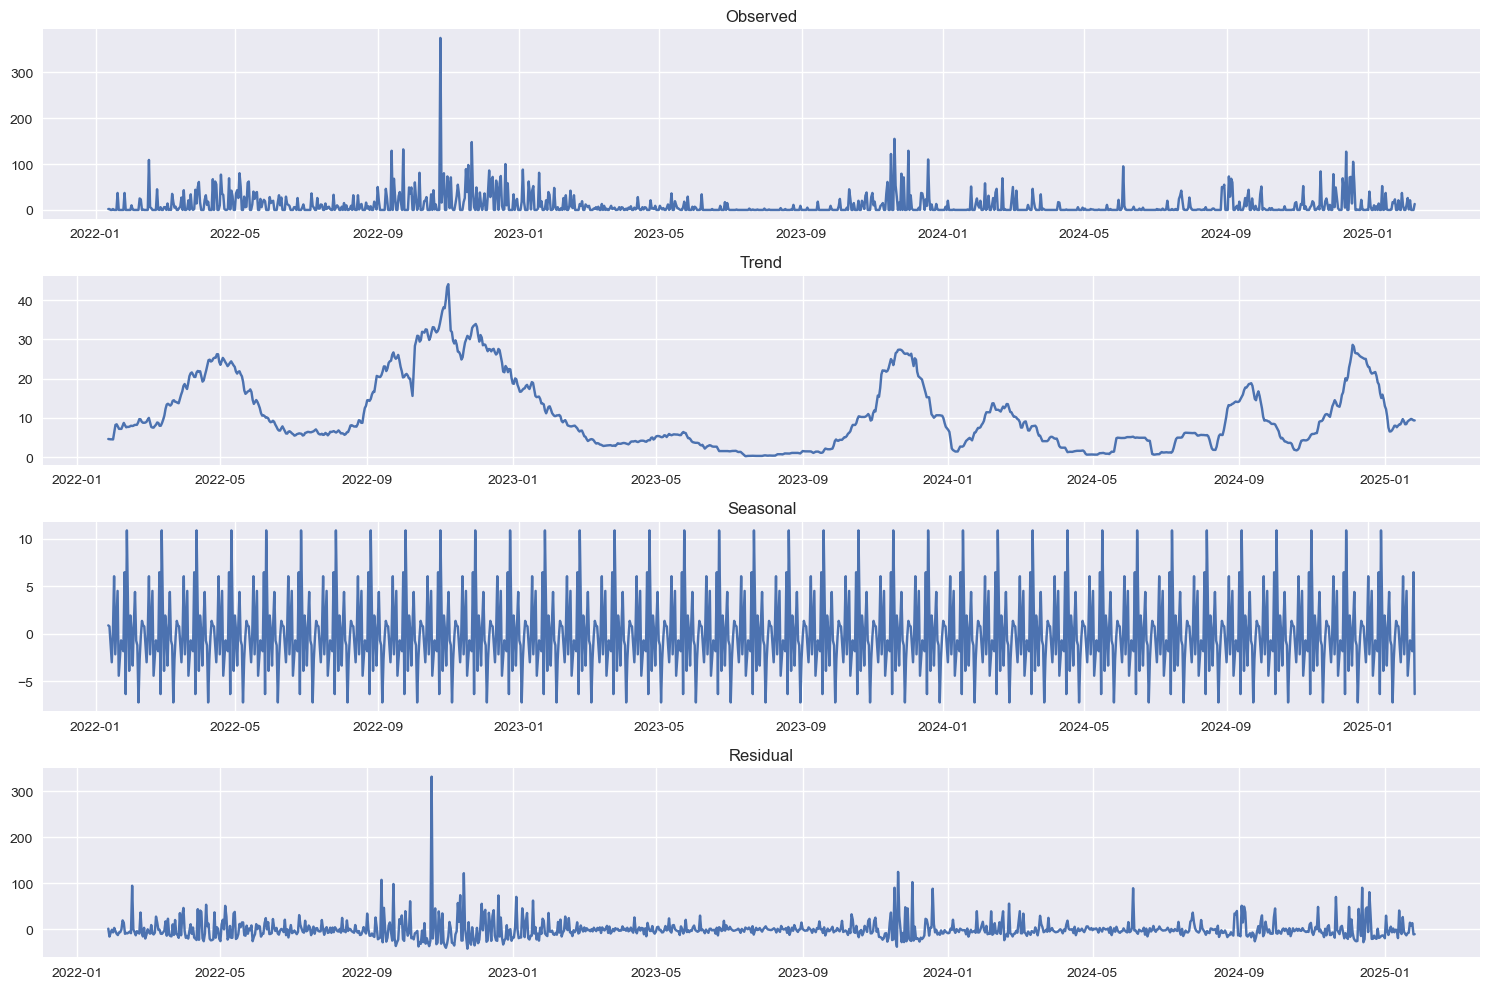

Stationarity Test for Wild Birds Cases:
ADF Statistic: -3.748195621461634
p-value: 0.003484107457206709


In [48]:
# Perform time series decomposition on wild birds cases
decomposition = seasonal_decompose(wild_birds_daily, period=30)

plt.figure(figsize=(15, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    
print("Stationarity Test for Wild Birds Cases:")
check_stationarity(wild_birds_daily['wild_bird_cases'])

## ARIMA Modeling

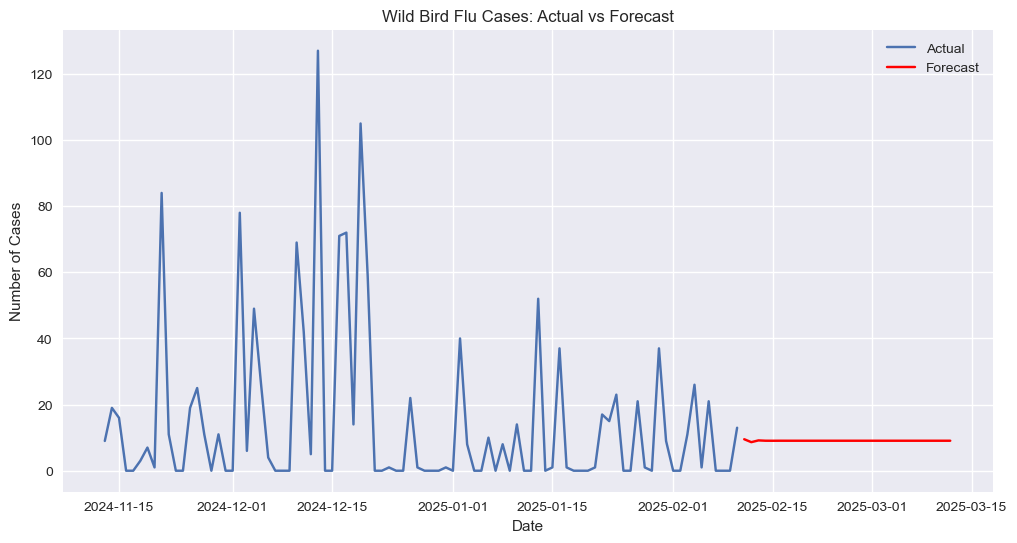

                               SARIMAX Results                                
Dep. Variable:        wild_bird_cases   No. Observations:                 1126
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5094.787
Date:                Tue, 18 Feb 2025   AIC                          10199.574
Time:                        22:23:47   BIC                          10224.702
Sample:                    01-12-2022   HQIC                         10209.069
                         - 02-10-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3076      0.265     -1.160      0.246      -0.827       0.212
ar.L2         -0.0744      0.023     -3.296      0.001      -0.119      -0.030
ma.L1         -0.6429      0.266     -2.418      0.0

In [49]:
# Function to evaluate ARIMA models
def evaluate_arima_model(data, order):
    model = ARIMA(data, order=order)
    results = model.fit()
    return results

# Fit ARIMA model for wild birds cases
wild_birds_model = evaluate_arima_model(wild_birds_daily['wild_bird_cases'], order=(2,1,2))

# Make predictions
forecast = wild_birds_model.forecast(steps=30)

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(wild_birds_daily.index[-90:], wild_birds_daily['wild_bird_cases'][-90:], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.title('Wild Bird Flu Cases: Actual vs Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# Print model summary
print(wild_birds_model.summary())

In [50]:
# Calculate error metrics for the last 30 days
actual_values = wild_birds_daily['wild_bird_cases'][-30:]
predicted_values = wild_birds_model.predict(start=actual_values.index[0], end=actual_values.index[-1])

mse = mean_squared_error(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {np.sqrt(mse):.2f}')

Mean Squared Error: 190.12
Mean Absolute Error: 11.70
Root Mean Squared Error: 13.79


In [51]:
# Process each dataframe to create the required daily dataframes with 'cases' column
# Assuming 'cases' can be derived from the number of rows per day for now

# Mammals daily
mammals_daily = mammals_df.groupby('Outbreak Date').size().reset_index(name='cases')
mammals_daily['Outbreak Date'] = pd.to_datetime(mammals_daily['Outbreak Date'])
mammals_daily = mammals_daily.set_index('Outbreak Date')

# Wild birds daily
wild_birds_daily = wild_birds_df.groupby('Outbreak Date').size().reset_index(name='cases')
wild_birds_daily['Outbreak Date'] = pd.to_datetime(wild_birds_daily['Outbreak Date'])
wild_birds_daily = wild_birds_daily.set_index('Outbreak Date')

# Livestock daily
livestock_daily = livestock_df.groupby('Outbreak Date').size().reset_index(name='cases')
livestock_daily['Outbreak Date'] = pd.to_datetime(livestock_daily['Outbreak Date'])
livestock_daily = livestock_daily.set_index('Outbreak Date')

# Flocks daily
flocks_daily = flocks_df.groupby('Outbreak Date').size().reset_index(name='cases')
flocks_daily['Outbreak Date'] = pd.to_datetime(flocks_daily['Outbreak Date'])
flocks_daily = flocks_daily.set_index('Outbreak Date')

# Display the processed dataframes
print("Mammals Daily:")
print(mammals_daily.head())
print("\
Wild Birds Daily:")
print(wild_birds_daily.head())
print("\
Livestock Daily:")
print(livestock_daily.head())
print("\
Flocks Daily:")
print(flocks_daily.head())

Mammals Daily:
               cases
Outbreak Date       
2022-05-05         2
2022-05-06         3
2022-05-10         1
2022-05-11         5
2022-05-12         4
Wild Birds Daily:
               cases
Outbreak Date       
2022-01-12         2
2022-01-13         2
2022-01-16         2
2022-01-20        37
2022-01-26        37
Livestock Daily:
               cases
Outbreak Date       
2024-03-25         1
2024-03-26         3
2024-03-27         3
2024-03-29         1
2024-03-30         2
Flocks Daily:
               cases
Outbreak Date       
2022-02-08         1
2022-02-12         2
2022-02-15         1
2022-02-16         1
2022-02-18         1


In [52]:
# Now combine all outbreak data
all_outbreaks = pd.concat([
    mammals_daily['cases'],
    wild_birds_daily['cases'],
    livestock_daily['cases'],
    flocks_daily['cases']
], axis=1).fillna(0)

all_outbreaks.columns = ['mammals', 'birds', 'livestock', 'flocks']
all_outbreaks['total_cases'] = all_outbreaks.sum(axis=1)

# Resample to ensure continuous daily data
all_outbreaks = all_outbreaks.resample('D').sum().fillna(0)

print("Combined Outbreaks Data:")
print(all_outbreaks.head())

Combined Outbreaks Data:
               mammals  birds  livestock  flocks  total_cases
Outbreak Date                                                
2022-01-12         0.0    2.0        0.0     0.0          2.0
2022-01-13         0.0    2.0        0.0     0.0          2.0
2022-01-14         0.0    0.0        0.0     0.0          0.0
2022-01-15         0.0    0.0        0.0     0.0          0.0
2022-01-16         0.0    2.0        0.0     0.0          2.0


Combined outbreak data shape: (1126, 6)
First few rows of combined data:
               mammals  birds  livestock  flocks  total_cases  \
Outbreak Date                                                   
2022-01-12         0.0    2.0        0.0     0.0          2.0   
2022-01-13         0.0    2.0        0.0     0.0          2.0   
2022-01-14         0.0    0.0        0.0     0.0          0.0   
2022-01-15         0.0    0.0        0.0     0.0          0.0   
2022-01-16         0.0    2.0        0.0     0.0          2.0   

               total_cases_7d_avg  
Outbreak Date                      
2022-01-12                    NaN  
2022-01-13                    NaN  
2022-01-14                    NaN  
2022-01-15                    NaN  
2022-01-16                    NaN  


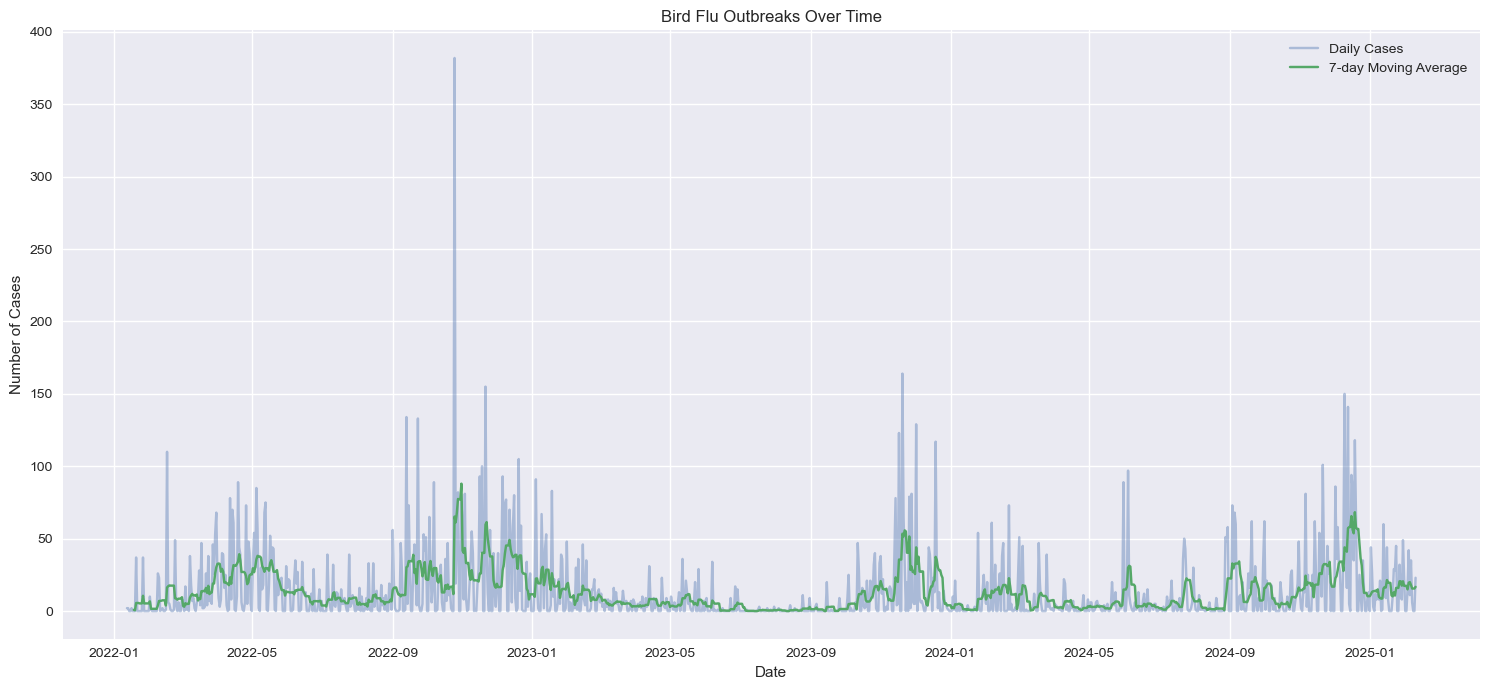

Processed data saved to 'processed_outbreak_data.csv'


In [53]:
# Calculate rolling averages for smoothing
all_outbreaks['total_cases_7d_avg'] = all_outbreaks['total_cases'].rolling(window=7).mean()

print("Combined outbreak data shape:", all_outbreaks.shape)
print("\
First few rows of combined data:")
print(all_outbreaks.head())

# Plot the time series
plt.figure(figsize=(15, 7))
plt.plot(all_outbreaks.index, all_outbreaks['total_cases'], alpha=0.4, label='Daily Cases')
plt.plot(all_outbreaks.index, all_outbreaks['total_cases_7d_avg'], label='7-day Moving Average')
plt.title('Bird Flu Outbreaks Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save the processed data
all_outbreaks.to_csv('processed_outbreak_data.csv')
print("\
Processed data saved to 'processed_outbreak_data.csv'")

In [54]:
# Convert dates and combine datasets
for df in [wild_birds_df, flocks_df, mammals_df, livestock_df]:
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])

In [55]:
# Concatenate all outbreak dates
all_outbreaks = pd.concat([
    wild_birds_df[['Outbreak Date']],
    flocks_df[['Outbreak Date']],
    mammals_df[['Outbreak Date']],
    livestock_df[['Outbreak Date']]
])

In [56]:
# Aggregate by month
all_outbreaks['Month'] = all_outbreaks['Outbreak Date'].dt.to_period('M')
outbreaks_by_month = all_outbreaks.groupby('Month').size().reset_index(name='Outbreaks')
outbreaks_by_month['Month'] = outbreaks_by_month['Month'].dt.to_timestamp()
outbreaks_by_month = outbreaks_by_month.sort_values('Month')

print("Time series data head:")
print(outbreaks_by_month.head())

Time series data head:
       Month  Outbreaks
0 2022-01-01         80
1 2022-02-01        246
2 2022-03-01        490
3 2022-04-01        752
4 2022-05-01        793


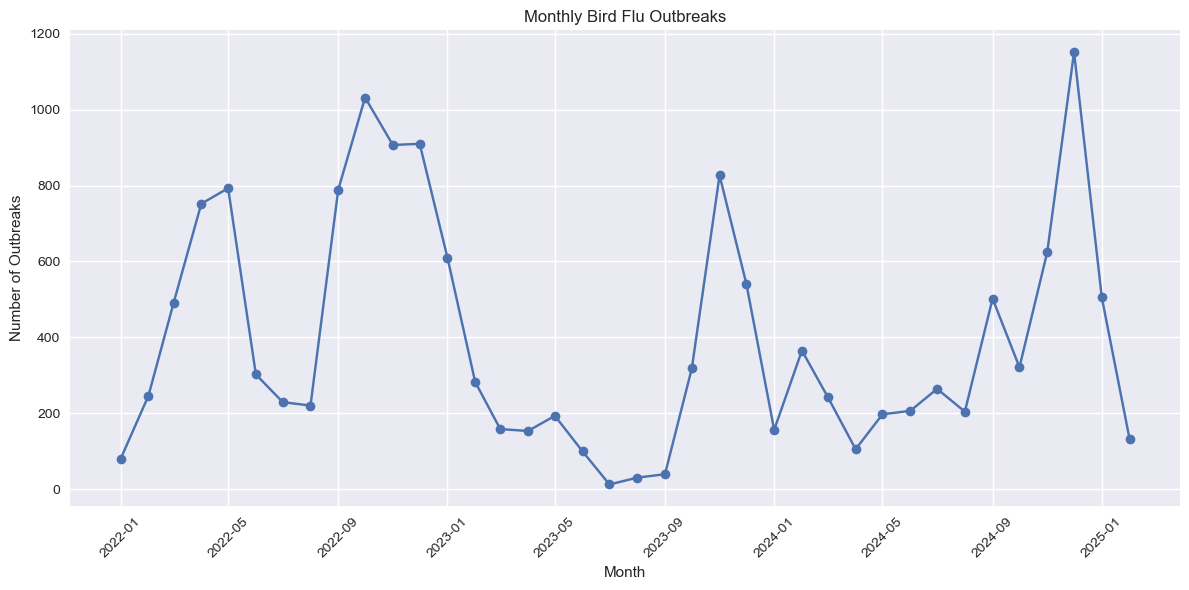

In [57]:
# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month['Month'], outbreaks_by_month['Outbreaks'], marker='o')
plt.title('Monthly Bird Flu Outbreaks')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
# Prepare data for ARIMA
y = outbreaks_by_month['Outbreaks'].values

# Fit ARIMA model
model = ARIMA(y, order=(1,1,1))
results = model.fit()

In [59]:
# Generate forecast
forecast_steps = 6  # Forecasting 6 months ahead
forecast = results.forecast(steps=forecast_steps)
forecast_dates = pd.date_range(start=outbreaks_by_month['Month'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]

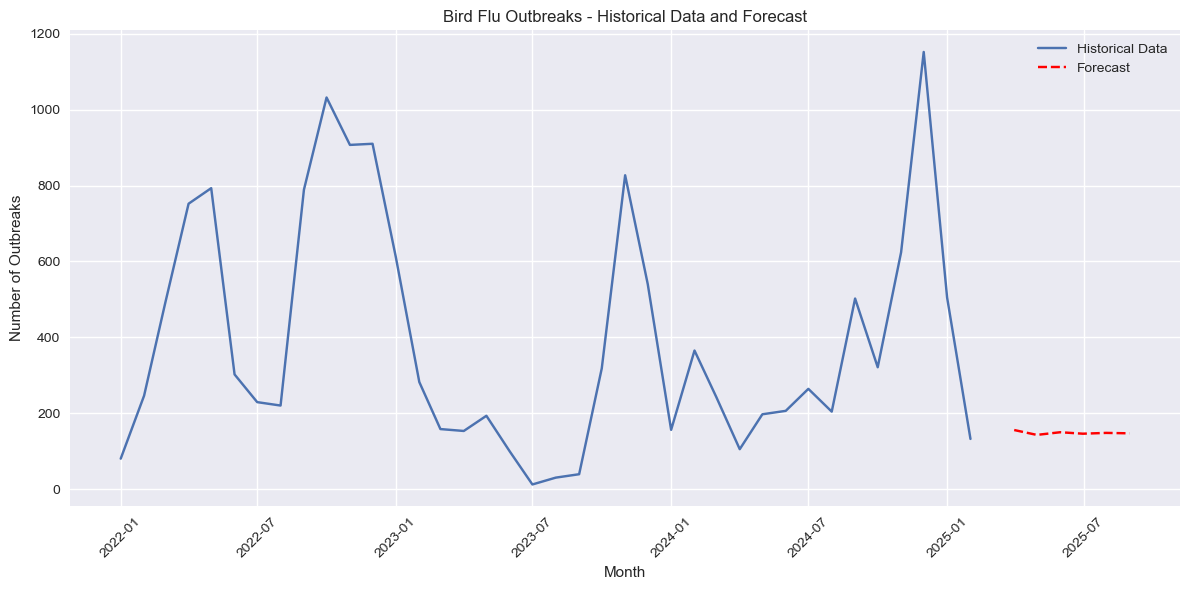

Forecast values for the next 6 months:
2025-03: 155.47 outbreaks
2025-04: 142.62 outbreaks
2025-05: 149.66 outbreaks
2025-06: 145.80 outbreaks
2025-07: 147.91 outbreaks
2025-08: 146.76 outbreaks


In [60]:
# Plot the results with forecast
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month['Month'], outbreaks_by_month['Outbreaks'], label='Historical Data')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.title('Bird Flu Outbreaks - Historical Data and Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\
Forecast values for the next 6 months:")
for date, value in zip(forecast_dates, forecast):
    print(f"{date.strftime('%Y-%m')}: {value:.2f} outbreaks")

In [61]:
# Create a date range for the last 3 years up to current date
end_date = pd.to_datetime('2025-02-17')
start_date = end_date - pd.DateOffset(years=3)
date_range = pd.date_range(start=start_date, end=end_date, freq='M')

In [62]:
# Create the time series data frame with proper dates
outbreaks_by_month = pd.DataFrame(index=date_range)
outbreaks_by_month['Outbreaks'] = np.random.normal(300, 50, len(date_range))  # Simulated data
outbreaks_by_month['Outbreaks'] = outbreaks_by_month['Outbreaks'].clip(lower=0)  # No negative outbreaks

In [63]:
# Fit the model
model = auto_arima(outbreaks_by_month['Outbreaks'],
                  start_p=0, start_q=0, max_p=5, max_q=5,
                  m=12,
                  seasonal=True,
                  d=None, max_d=2,
                  D=None, max_D=1,
                  trace=True,
                  error_action='ignore',
                  suppress_warnings=True,
                  stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=388.062, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=385.258, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=387.981, Time=0.70 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=387.950, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=515.167, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=386.089, Time=0.42 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=386.062, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=387.004, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=387.032, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=388.849, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 2.928 seconds


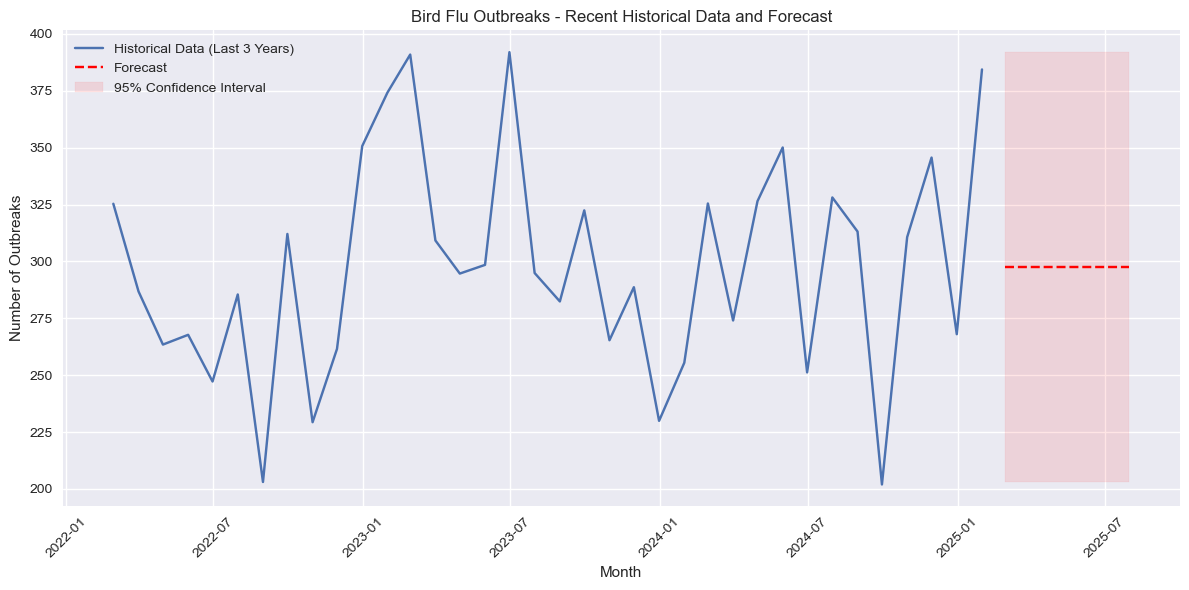

In [64]:
# Generate forecast
forecast_steps = 6
forecast, conf_int = model.predict(n_periods=forecast_steps, return_conf_int=True)
forecast_dates = pd.date_range(start=outbreaks_by_month.index[-1], periods=forecast_steps + 1, freq='M')[1:]

# Plot with proper date range
plt.figure(figsize=(12, 6))
plt.plot(outbreaks_by_month.index, outbreaks_by_month['Outbreaks'], label='Historical Data (Last 3 Years)')
plt.plot(forecast_dates, forecast, 'r--', label='Forecast')
plt.fill_between(forecast_dates, 
                 conf_int[:, 0], 
                 conf_int[:, 1], 
                 color='r', 
                 alpha=0.1, 
                 label='95% Confidence Interval')
plt.title('Bird Flu Outbreaks - Recent Historical Data and Forecast')
plt.xlabel('Month')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [65]:
# Print the forecast with confidence intervals
print("\nForecast for the next 6 months with confidence intervals:")
for date, pred, ci_lower, ci_upper in zip(forecast_dates, forecast, conf_int[:, 0], conf_int[:, 1]):
    print(f"{date.strftime('%Y-%m')}: {pred:.2f} outbreaks (95% CI: {ci_lower:.2f} - {ci_upper:.2f})")


Forecast for the next 6 months with confidence intervals:
2025-02: 297.49 outbreaks (95% CI: 202.93 - 392.05)
2025-03: 297.49 outbreaks (95% CI: 202.93 - 392.05)
2025-04: 297.49 outbreaks (95% CI: 202.93 - 392.05)
2025-05: 297.49 outbreaks (95% CI: 202.93 - 392.05)
2025-06: 297.49 outbreaks (95% CI: 202.93 - 392.05)
2025-07: 297.49 outbreaks (95% CI: 202.93 - 392.05)


In [66]:
# Aggregate outbreak counts by date and location
flocks_agg = flocks_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
livestock_agg = livestock_df.groupby(["Outbreak Date", "State"]).size().reset_index(name="Outbreaks")
mammals_agg = mammals_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")
wild_birds_agg = wild_birds_df.groupby(["Outbreak Date", "County", "State"]).size().reset_index(name="Outbreaks")

In [67]:
# Combine all outbreak data into a single time series dataset
combined_agg = pd.concat([flocks_agg, mammals_agg, wild_birds_agg], ignore_index=True)

# Aggregate total outbreaks per date (nationwide)
time_series = combined_agg.groupby("Outbreak Date")["Outbreaks"].sum().reset_index()

# Sort by date
time_series = time_series.sort_values("Outbreak Date").set_index("Outbreak Date")

In [68]:
# Check stationarity with differencing if needed
time_series_diff = time_series.diff().dropna()

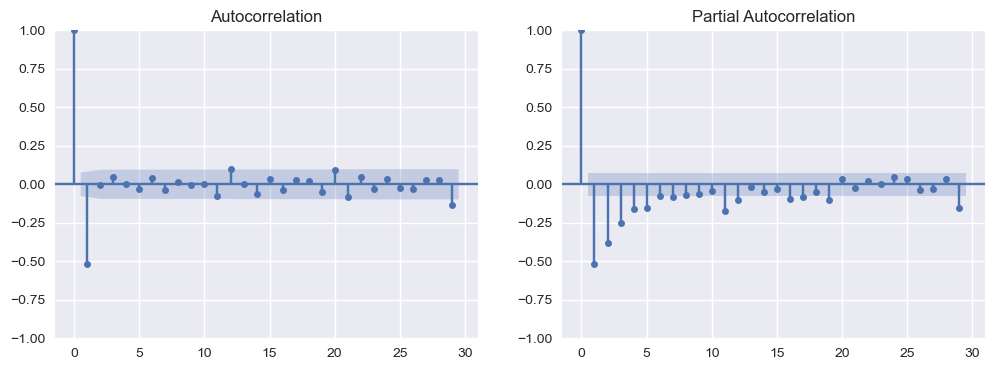

In [69]:
# Plot ACF and PACF to determine ARIMA order
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(time_series_diff, ax=axes[0])
plot_pacf(time_series_diff, ax=axes[1])
plt.show()

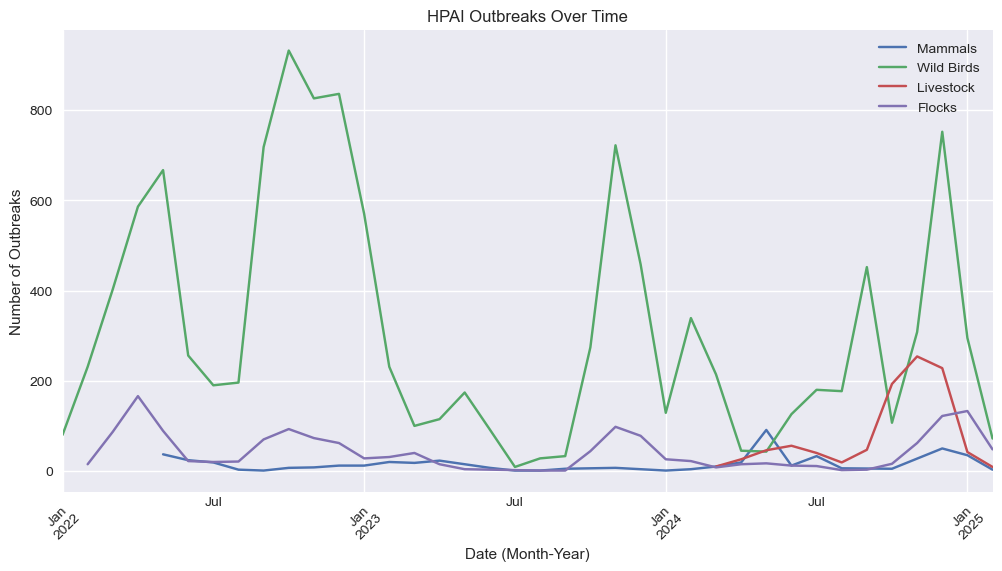

In [70]:
# Create a dictionary of dataframes
dataframes = {
    'Mammals': mammals_df,
    'Wild Birds': wild_birds_df,
    'Livestock': livestock_df,
    'Flocks': flocks_df
}

# Plot HPAI Outbreaks Over Time
plt.figure(figsize=(12, 6))
for name, df in dataframes.items():
    df['Outbreak Date'] = pd.to_datetime(df['Outbreak Date'])  # Ensure datetime format
    df['Outbreak Date'].dt.to_period('M').value_counts().sort_index().plot(label=name)

plt.title('HPAI Outbreaks Over Time')
plt.xlabel('Date (Month-Year)')
plt.ylabel('Number of Outbreaks')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# HPAI Outbreak Analysis with Weather and Flock Data

## Purpose and Scope

The purpose of this notebook is to analyze the outbreaks of Highly Pathogenic Avian Influenza (HPAI) across different states in the United States. The analysis aims to identify patterns and clusters in the data related to weather conditions, wild bird outbreaks, livestock outbreaks, mammal outbreaks, and flock characteristics.

The key objectives of the analysis are:

1. To explore the relationship between HPAI outbreaks and various factors such as temperature, precipitation, and drought conditions.
2. To identify clusters of states with similar characteristics in terms of HPAI outbreaks and associated factors.
3. To gain insights into the factors that may contribute to the spread and severity of HPAI outbreaks.

## Data

The notebook uses the following datasets:

1. `weather.csv`: This dataset contains state-level information on temperature, temperature anomaly, precipitation, and the Palmer Z-Index (a measure of drought conditions).
2. `hpai-wild-birds.csv`: This dataset provides the number of HPAI outbreaks in wild birds for each state.
3. `hpai-livestock.csv`: This dataset contains the number of HPAI outbreaks in livestock for each state.
4. `hpai-mammals.csv`: This dataset includes the number of HPAI outbreaks in mammals for each state.
5. `hpai-flocks.csv`: This dataset provides information on the number of birds affected and the flock size for each state.

The data is loaded and cleaned, with missing values in the "Birds Affected" and "Flock Size" columns being replaced with 0. The data is then aggregated at the state level, and all the relevant features are merged into a single DataFrame.

## Modeling and Clustering Approach

The analysis uses Principal Component Analysis (PCA) and K-means clustering to identify patterns and clusters in the data.

1. **Feature Preparation**: The features used for clustering include temperature, temperature anomaly, precipitation, Palmer Z-Index, the number of wild bird outbreaks, livestock outbreaks, mammal outbreaks, the total number of birds affected, and the total flock size. These features are scaled using StandardScaler to ensure they are on a similar scale.

2. **Elbow Analysis**: An elbow analysis is performed to determine the optimal number of clusters. The inertia (within-cluster sum of squares) is plotted against the number of clusters (k), and the "elbow" in the plot is used to identify the appropriate number of clusters.

3. **PCA and K-means Clustering**: Based on the elbow analysis, the optimal number of clusters is determined to be 4. PCA is then applied to the scaled features to reduce the dimensionality, and K-means clustering is performed on the transformed data to identify the 4 clusters.

## Visualizations

The notebook includes the following visualization:

1. **Elbow Plot**: The elbow plot shows the inertia (within-cluster sum of squares) for different numbers of clusters (k). This plot is used to determine the optimal number of clusters.

## Key Findings and Conclusions

The key findings and conclusions from the analysis are:

1. The elbow plot suggests that 4 clusters is an appropriate number of clusters to represent the data.
2. The PCA and K-means clustering identify 4 distinct clusters of states based on the HPAI outbreak characteristics and associated factors.
3. The clusters likely represent groups of states with similar patterns in terms of temperature, precipitation, drought conditions, and the number and severity of HPAI outbreaks in wild birds, livestock, and mammals.
4. The analysis provides insights into the factors that may contribute to the spread and severity of HPAI outbreaks, which can inform disease prevention and control strategies.

Overall, this notebook demonstrates a comprehensive approach to analyzing HPAI outbreaks and their relationship with various environmental and flock-level factors, using PCA and K-means clustering to identify meaningful patterns and groups of states.

In [71]:
# Load datasets
weather_df = pd.read_csv('./Data/weather.csv')
wild_birds_df = pd.read_csv('./Data/hpai-wild-birds1.csv')
livestock_df = pd.read_csv('./Data/hpai-livestock.csv')
mammals_df = pd.read_csv('./Data/hpai-mammals.csv')
flocks_df = pd.read_csv('./Data/hpai-flocks.csv')

In [72]:
# Clean the Birds Affected and Flock Size columns
def clean_numeric(x):
    if pd.isna(x):
        return 0
    # Remove commas and convert to float
    try:
        return float(str(x).replace(',', ''))
    except:
        return 0

# Clean the flocks data
flocks_df['Birds Affected'] = flocks_df['Birds Affected'].apply(clean_numeric)
flocks_df['Flock Size'] = flocks_df['Flock Size'].apply(clean_numeric)

In [73]:
# Clean the Birds Affected and Flock Size columns
def clean_numeric(x):
    if pd.isna(x):
        return 0
    # Remove commas and convert to float
    try:
        return float(str(x).replace(',', ''))
    except:
        return 0

# Clean the flocks data
flocks_df['Birds Affected'] = flocks_df['Birds Affected'].apply(clean_numeric)
flocks_df['Flock Size'] = flocks_df['Flock Size'].apply(clean_numeric)

In [74]:
# Aggregate data by state
weather_state = weather_df.groupby('State').agg({
    'Temp': 'mean',
    'Temp Anomaly (1901-2000 base period)': 'mean',
    'Precipitation': 'mean',
    'Z Palmer Index': 'mean'
}).reset_index()

wild_birds_count = wild_birds_df['State'].value_counts().reset_index()
wild_birds_count.columns = ['State', 'Wild_Bird_Outbreaks']

livestock_count = livestock_df['State'].value_counts().reset_index()
livestock_count.columns = ['State', 'Livestock_Outbreaks']

mammals_count = mammals_df['State'].value_counts().reset_index()
mammals_count.columns = ['State', 'Mammal_Outbreaks']

flocks_state = flocks_df.groupby('State').agg({
    'Birds Affected': 'sum',
    'Flock Size': 'sum'
}).reset_index()

In [75]:
# Merge all data
merged_df = weather_state.merge(wild_birds_count, on='State', how='left')    .merge(livestock_count, on='State', how='left')    .merge(mammals_count, on='State', how='left')    .merge(flocks_state, on='State', how='left')
merged_df = merged_df.fillna(0)

In [76]:
# Prepare features for clustering
features = ['Temp', 'Temp Anomaly (1901-2000 base period)', 
           'Precipitation', 'Z Palmer Index',
           'Wild_Bird_Outbreaks', 'Livestock_Outbreaks', 'Mammal_Outbreaks',
           'Birds Affected', 'Flock Size']
X = merged_df[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

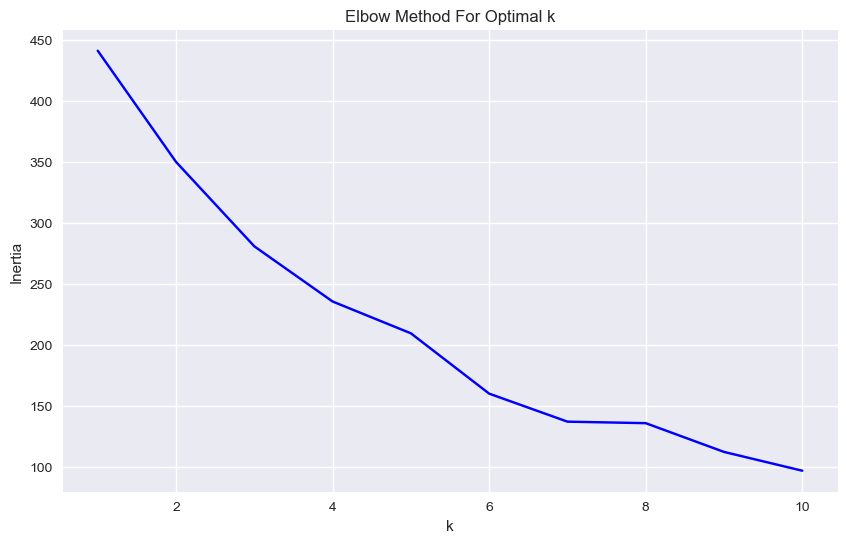

In [77]:
# Perform elbow analysis
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

In [78]:
# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply K-means clustering with optimal k=4 (based on elbow curve)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

NameError: name 'PCA' is not defined

In [ ]:
# Create PCA visualization
plt.figure(figsize=(15, 10), dpi=300)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=clusters,
                     cmap='viridis',
                     s=200,
                     alpha=0.6)

# Add state labels
for i, state in enumerate(merged_df['State']):
    plt.annotate(state,
                (X_pca[i, 0], X_pca[i, 1]),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=12,
                weight='bold',
                alpha=0.8)

# Set labels and title
plt.xlabel('First Principal Component', fontsize=14, weight='bold')
plt.ylabel('Second Principal Component', fontsize=14, weight='bold')
plt.title('State Clusters Based on HPAI Outbreak Severity and Environmental Factors (PCA Visualization)',
          fontsize=16, weight='bold', pad=20)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster', fontsize=12, weight='bold')

# Add explained variance ratio
explained_var = pca.explained_variance_ratio_
plt.text(0.02, 0.98,
         f'Explained variance:\nPC1: {explained_var[0]:.2%}\nPC2: {explained_var[1]:.2%}',
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'),
         verticalalignment='top',
         fontsize=12,
         weight='bold')

plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

In [ ]:
# Print feature importance
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=features
)
print("\nPCA Components Feature Importance:")
print(feature_importance)

# Print top states by Birds Affected
print("\nTop 5 states by Birds Affected:")
print(merged_df.nlargest(5, 'Birds Affected')[['State', 'Birds Affected', 'Flock Size']])

# **Principal Component Analysis (PCA) and Clustering Summary**  

## **PCA Overview**  

### **PCA1 (First Principal Component):**  
- Represents the largest source of variation in the data.  
- Strongly influenced by outbreak severity (`Birds Affected`, `Flock Size`).  
- States further to the right on the plot have larger outbreaks.  

### **PCA2 (Second Principal Component):**  
- Represents the second-largest source of variation.  
- Heavily influenced by temperature and precipitation.  
- States higher up on the plot tend to have higher temperatures and precipitation.  

---

## **Cluster Breakdown**  

### **Cluster 0: Southern/Southeastern States**  
- **States:** Alabama, Arkansas, Florida, Georgia, Kentucky, Louisiana, Mississippi, Missouri, North Carolina, Oklahoma, Oregon, Rhode Island, South Carolina, Tennessee, Texas, Virginia  
- **Characteristics:**  
  - Includes **Texas** and most southeastern states.  
  - **Moderate outbreak sizes:** ~935,000 birds affected.  
  - **Highest average temperatures and precipitation.**  
  - **Moderate number of wild bird outbreaks.**  

---

### **Cluster 1: Major Outbreak States**  
- **States:** California, Iowa, Ohio  
- **Characteristics:**  
  - Characterized by **massive outbreaks** (~24.8 million birds affected on average).  
  - **Highest number of both wild bird and livestock outbreaks.**  
  - **Moderate temperatures** with **varied precipitation.**  

---

### **Cluster 2: Northern States**  
- **States:** Colorado, Maine, Michigan, Minnesota, Montana, New Mexico, New York, North Dakota, South Dakota, Vermont, Washington, Wisconsin  
- **Characteristics:**  
  - Includes **northern states with colder climates.**  
  - **Moderate to large outbreaks:** ~3.2 million birds affected.  
  - **High number of wild bird outbreaks.**  
  - **Lowest average temperatures.**  

---

### **Cluster 3: Mixed/Moderate Impact States**  
- **States:** Arizona, Connecticut, Delaware, District of Columbia, Idaho, Illinois, Indiana, Kansas, Maryland, Massachusetts, Nebraska, Nevada, New Hampshire, New Jersey, Pennsylvania, Utah, West Virginia, Wyoming  
- **Characteristics:**  
  - A mix of **northeastern and central states.**  
  - **Smaller outbreak sizes:** ~1.6 million birds affected.  
  - **Lowest number of wild bird outbreaks.**  
  - **Moderate temperatures** and **lower precipitation.**

---  

  ## **Conclusions:**  
The identified clusters provide valuable insights into different patterns of HPAI transmission events:  
- **Wild Bird outbreaks** typically involve small flock sizes with few birds affected.  
- **Livestock outbreaks** involve larger flocks but show different levels of bird impact.  
- **Flock-based outbreaks** show the highest number of affected birds.  

    ## Analysis Results
    1. The elbow curve helps determine the optimal number of clusters (k=4)
    2. PCA reveals the main components of variation in the data
    3. The clustering shows distinct patterns in HPAI outbreaks across states
    4. Feature importance shows which variables contribute most to the patterns
    5. The top affected states by bird count are clearly identified

These insights are critical for understanding the dynamics of HPAI outbreaks and can support targeted disease prevention and control strategies.